<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [9]</a>'.</span>

In [1]:
#Setup the google drive
import os
#from google.colab import drive
#drive.mount('/content/gdrive')
#os.listdir('/content/gdrive/MyDrive')
#Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
#Keras/TensorFlow
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, Concatenate, Dense, Add
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
#Keras image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
#Seaborn
import seaborn as sns #

2024-12-02 11:39:16.571036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 11:39:17.145333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 11:39:17.312818: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 11:39:18.356588: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-12-02 11:39:22.329432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# can replace wit full trainPath and TestPath
curPath = os.getcwd()
trainPath = curPath + '/TRAIN'
testPath = curPath + '/TEST'


trainIDs = next(os.walk(trainPath))[1]  # IDs, refers to 6-digit identifier (ie 000000)
train_x = []
train_y = []

for id in trainIDs:
    imPath = trainPath + '/' + id
    imNames = next(os.walk(imPath))[2]  # this will break if there are not at least 3 images in each subdir
    train_x.append([tf.keras.utils.load_img(imPath + '/' + imNames[0], target_size=(256,256)), \
                    tf.keras.utils.load_img(imPath + '/' + imNames[1], target_size=(256,256))])
    train_y.append(tf.keras.utils.load_img(imPath + '/' + imNames[2], target_size=(256,256)))

train_x = np.array(train_x)
train_y = np.array(train_y)

testIDs = next(os.walk(testPath))[1]  # IDs, refers to 6-digit identifier (ie 000000)
test_x = []
test_y = []

for id in testIDs:
    imPath = testPath + '/' + id
    imNames = next(os.walk(imPath))[2]  # this will break if there are not at least 3 images in each subdir
    test_x.append([tf.keras.utils.load_img(imPath + '/' + imNames[0], target_size=(256,256)), \
                    tf.keras.utils.load_img(imPath + '/' + imNames[1], target_size=(256,256))])
    test_y.append(tf.keras.utils.load_img(imPath + '/' + imNames[2], target_size=(256,256)))

test_x = np.array(test_x)
test_y = np.array(test_y)

(514, 256, 256)


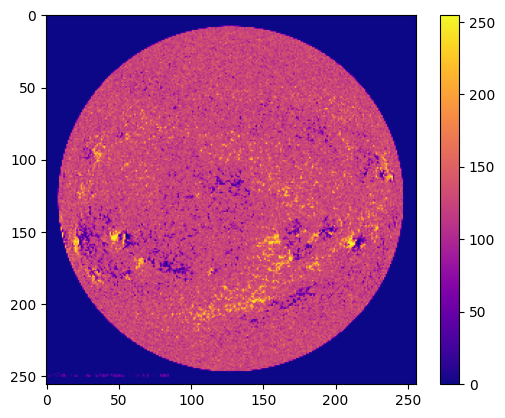

In [3]:
# x shape (bs, 2)
# y shape (bs)
# images are three channels, but only one is needed since grayscale
fig, ax = plt.subplots(1)

pos = ax.imshow(train_y[0][:,:,0], cmap='plasma')
fig.colorbar(pos, ax=ax)
print(train_y[:,:,:,0].shape)

In [4]:
# kernel = (4,4)
# pool_size = (2,2)
# filters = 32
# loss_rate = 1e-4
# epochs = 2
# batch_size = 128
# val_split = 0.15
# hyperparameters = [kernel,pool_size]

# class customModel(tf.keras.Model):
#     def __init__(self, hyperparameters):
#         super().__init__()
#         self.inp1 = Input(shape=(1024,1024,1))
#         self.inp2 = Input(shape=(1024,1024,1))
#         self.cat = Concatenate(axis=1)
#         self.conv1 = Conv2D(filters, kernel, padding = 'same', activation='relu')
#         self.pool1 = MaxPooling2D(pool_size=pool_size)
#         self.conv2 = Conv2D(filters,kernel, padding = 'same',activation='relu')
#         self.pool2 = MaxPooling2D(pool_size=pool_size)
#         self.tconv1 = Conv2DTranspose(filters, kernel, strides=pool_size, padding = 'same') #Upsampling to get back to 1024x1024
#         self.tconv2 = Conv2DTranspose(1, kernel, strides=pool_size, padding = 'same')
#     def call(self, inputs):
#         x1 = inputs[0]
#         x2 = inputs[1]
#         x = self.cat([x1,x2])
#         x = self.conv1(x)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.pool2(x)
#         x = self.tconv1(x)
#         return self.tconv2(x)


# model = customModel('dum')
# model.compile(optimizer=Adam(loss_rate),loss='mean_squared_error',metrics=['accuracy'])
# checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='min')
# history=model.fit([train_x[:,0], train_x[:,1]], train_y, epochs=epochs, batch_size=batch_size, callbacks=checkpoint)

In [5]:
kernel = (4,4)
pool_size = (2,2)
filters = [4, 8]
loss_rate = 1e-4
epochs = 10
batch_size = 128
val_split = 0.15

x1 = Input(shape=(256,256,1))
x2 = Input(shape=(256,256,1))
x = Add()([x1,x2])
x = Conv2D(filters[0], kernel, padding = 'same', activation='relu')(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Conv2D(filters[0],kernel, padding = 'same',activation='relu')(x)
x = Dense(1, activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)    # editted this line to change dimension sizes
x = Conv2DTranspose(filters[0], kernel, strides=pool_size, padding = 'same')(x) #Upsampling to get back to 1024x1024
x = Conv2DTranspose(1, kernel, strides=pool_size, padding = 'same')(x)

# # Alternative to MSE loss
# def SSIMLoss(y_true, y_pred):
#   return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))


model = Model(inputs=[x1,x2], outputs=x)
model.compile(optimizer=Adam(loss_rate),loss='MAE')
model.summary()
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
history=model.fit([train_x[:,0,:,:,0], train_x[:,1,:,:,0]], train_y[:,:,:,0], epochs=epochs, verbose=True, batch_size=batch_size, validation_split = val_split, callbacks=checkpoint)

2024-12-02 11:40:36.818608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14784 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ input_layer[0][0… │
│                     │ 1)                │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │         68 │ add[0][0]         │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        260 │ max_pooling2d[0]… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 128,  │          5 │ conv2d_1[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64, 1) │          0 │ dense[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │         68 │ max_pooling2d_1[… │
│ (Conv2DTranspose)   │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 256, 256,  │         65 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 466 (1.82 KB)

 Trainable params: 466 (1.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/home/abedel/.conda/envs/tfgpu/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


I0000 00:00:1733157646.533485 1269905 service.cc:146] XLA service 0x15150808a6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733157646.533516 1269905 service.cc:154]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0


2024-12-02 11:40:46.969318: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2024-12-02 11:40:47.858888: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 86.4828

1/4 ━━━━━━━━━━━━━━━━━━━━ 49s 16s/step - loss: 86.4639

I0000 00:00:1733157660.955956 1269905 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - loss: 86.4921

4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 811ms/step - loss: 86.4936 - val_loss: 86.5879


Epoch 2/10


1/4 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 86.4625

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 86.4884

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - loss: 86.4923 - val_loss: 86.5867


Epoch 3/10


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - loss: 86.4613

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 86.4872 

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 86.4911 - val_loss: 86.5856


Epoch 4/10


1/4 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 86.4603

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 86.4862

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - loss: 86.4901 - val_loss: 86.5847


Epoch 5/10


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step - loss: 86.4594

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 86.4853 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - loss: 86.4892 - val_loss: 86.5839


Epoch 6/10


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step - loss: 86.4586

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 86.4846 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 86.4885 - val_loss: 86.5832


Epoch 7/10


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 86.4579

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 86.4863 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 86.4878 - val_loss: 86.5826


Epoch 8/10


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 86.4573

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 86.4833 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 86.4872 - val_loss: 86.5821


Epoch 9/10


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 86.4568

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 86.4828

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 86.4867 - val_loss: 86.5816


Epoch 10/10


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 86.4563

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 86.4848 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 86.4863 - val_loss: 86.5812


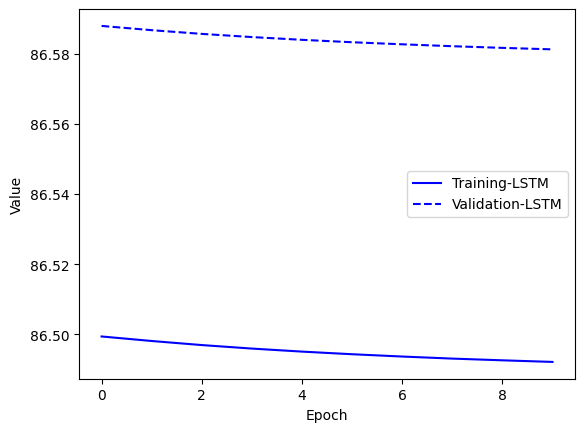

In [6]:
mae = history.history['loss']
vmae = history.history['val_loss']
plt.figure()
plt.plot(mae, label='Training-LSTM',color='blue',linestyle='-')
plt.plot(vmae, label='Validation-LSTM',color='blue',linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

In [7]:
model_best = load_model('best_model.keras')
best_eval = model_best.evaluate([test_x[:,0,:,:,0], test_x[:,1,:,:,0]], test_y,verbose=2)
new_images = model_best.predict([test_x[:,0,:,:,0], test_x[:,1,:,:,0]])

/home/abedel/.conda/envs/tfgpu/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer', 'input_layer_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


5/5 - 1s - 203ms/step - loss: 86.4842


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


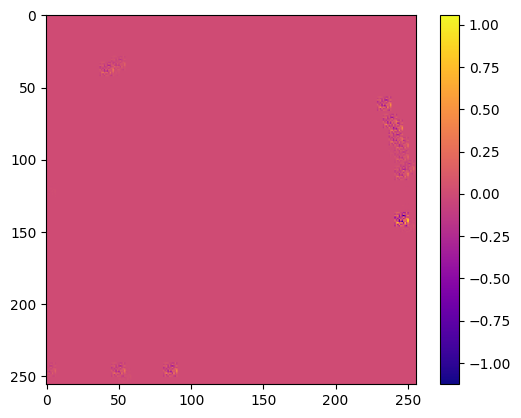

In [8]:
plt.imshow(new_images[0], cmap='plasma')
plt.colorbar()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [9]:
diff = []
image_mean = []
image_std = []

for i in new_images:
  diff.append(np.array(new_images[i]) - np.array(test_y[i]))
  image_mean.append(np.mean(diff[i]))
  image_std.append(np.std(diff[i]))

total_mean = np.mean(image_mean)
total_std = np.std(image_std)
print("The mean of the pixel differences is ", total_mean, " +/- ", total_std)

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
n = 10
for i in range(n):
        i = np.random.randint(0,diff.shape[0]) # choose a random number between 0 and len(X_te)
        plt.figure()
        plt.imshow(diff[i], cmap='gray')
        plt.title('Difference between true image and predicted image for the ' + str(i) + 'th image')
        plt.colorbar()

        plt.show()